In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

ROOT = "."
SIM = 0 # choose
FIGURES_FOLDER = ROOT + f"/Figures/sim{SIM}/"
SIM_FOLDER = ROOT + f"/Simulations/sim{SIM}/"

if not os.path.exists(FIGURES_FOLDER):
    os.mkdir(FIGURES_FOLDER)
if not os.path.exists(SIM_FOLDER):
    os.mkdir(SIM_FOLDER)

C:\Users\nicol\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def G(rho, p, P):
  return p*(1-rho/P)

# 1D parameter derivation:
# delta^2 / (1*tau) -> D for delta, tau -> 0
# Du = theta_u * D
# Di = theta_i * D

delta = 0.05 # mm
tau = 0.2 # h
D = delta**2/(2*tau)
Du = Di = 1.88e-4 # mm^2/h
theta_u = Du/D
theta_i = Di/D
beta = 1.02e-1 # h-1
p	= 1.87e-2 # h-1
q	= 4.17e-2 # h-1
P = K	= 1e3 # 1/mm^2
c_max = int(K*delta)
Ru = 2.6 # mm
Ri = 1 # mm
pop_unit = 1

In [3]:
def initialize_mesh(delta, Ru, Ri, c_max):
  initial_u = int(.9*c_max)
  initial_i = int(.1*c_max)
  size = int(1/delta * 10 * 2)
  domain = np.zeros((2, size), dtype='u1')
  uint8 = np.iinfo(np.uint8)
  print("max of dtype:", uint8.max, ". cmax: ",c_max)
  for i in range(size):
    if ((i-size/2)*delta)**2 <= (Ru)**2:
      domain[0][i] = initial_u
    if ((i-size/2)*delta)**2 <= (Ri)**2:
      domain[1][i] = initial_i
  return domain

domain = initialize_mesh(delta, Ru, Ri, c_max)

max of dtype: 255 . cmax:  50


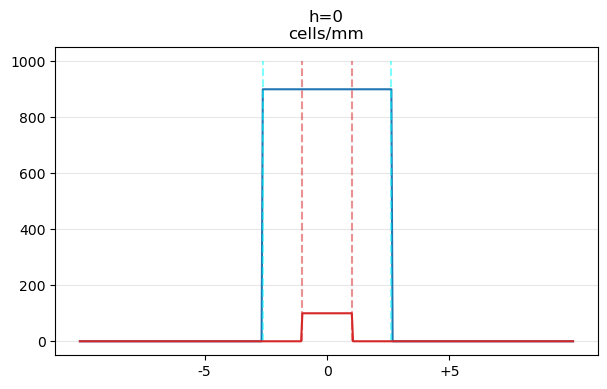

In [4]:
# define functions and parameters to save and plot results

def save_values(domain, h):
  np.save(f"{SIM_FOLDER}/sim{SIM}_h{h}.npy", domain)

size = int(1/delta * 10 * 2)
ticks = [size//2 - 5//delta, size//2, size//2 + 5//delta]

def plot_domain(domain, h):
  radius_u = (Ru + h*2*np.sqrt(Du*p))/delta
  radius_i = (Ri + h*2*np.sqrt(Di*(beta-q)))/delta
  fig, ax = plt.subplots(figsize=(7, 4))

  # plot U
  plt.plot(np.divide(domain[0],delta), color="tab:blue")
  ax.set_xticks(ticks)
  ax.set_xticklabels(["-5","0","+5"],rotation=0)
  ax.title.set_text(f"h={h}\ncells/mm")
  plt.vlines([size//2 + radius_u, size//2 - radius_u], 0, c_max/delta, colors=["cyan"], linestyles="dashed", alpha=0.5)
  # plot I
  plt.plot(np.divide(domain[1],delta), color="tab:red")
  plt.vlines([size//2 - radius_i, size//2 + radius_i], 0, c_max/delta, colors=["tab:red"], linestyles="dashed", alpha=0.5)
  ax.yaxis.grid(alpha=0.3)
  # save and plot figure
  # plt.savefig(f"{FIGURES_FOLDER}/random_walk_sim{SIM}_h{h}.png", format='png', dpi=200)
  plt.show()

plot_domain(domain, 0)

In [5]:
# def simulation functions

def random_move(space_next, cell_type, i, p_unit):
  prob_dist = [1-theta_u, theta_u/2, theta_u/2]
  action = np.random.choice(["stay", "right", "left"], p=prob_dist)

  if action == "right" and i < space_next.shape[1]:
    space_next[cell_type][i] -= p_unit
    space_next[cell_type][i+1] += p_unit
  elif action == "left" and i > 0:
    space_next[cell_type][i] -= p_unit
    space_next[cell_type][i-1] += p_unit

def select_u_action(space, space_next, i):
  cell_type = 0
  # reproduce or die or nothing:
  if space[0][i]+space[1][i] >= c_max:
    prob_to_die = max(-tau*p*(1-(space[0][i]+space[1][i])/c_max), 0)
    prob_dist = [1-prob_to_die, prob_to_die]
    action = np.random.choice(["live","die"], p=prob_dist)
    if action == "die":
      space[0][i] -= pop_unit
      space_next[0][i] -= pop_unit
      return
  else:
    prob_to_reproduce = max(tau*p*(1-(space[0][i]+space[1][i])/c_max), 0)
    prob_dist = [1-prob_to_reproduce, prob_to_reproduce]
    action = np.random.choice(["nothing","reproduce"], p=prob_dist)
    if action == "reproduce":
      space_next[0][i] += pop_unit

  # infect or not
  prob_to_infect = tau*beta*space[1][i]/c_max
  prob_dist = [1-prob_to_infect, prob_to_infect]
  action = np.random.choice(["no","infected"], p=prob_dist)
  if action == "infected":
    space_next[0][i] -= pop_unit
    space_next[1][i] += pop_unit
    cell_type = 1

  # move or stay
  random_move(space_next, cell_type, i, pop_unit)

def select_i_action(space, space_next, i):
  cell_type = 1
  # live or die:
  prob_to_die = tau*q
  prob_dist = [1-prob_to_die, prob_to_die]
  action = np.random.choice(["live","die"], p=prob_dist)
  if action == "die":
    space_next[1][i] -= 1
    return

  # move or stay
  random_move(space_next, cell_type, i, 1)

def random_walk_1D(space, space_next, tot_hours, h=0):
  time_steps = int((tot_hours-h)/tau)
  for time in range(time_steps):
    for i in range(space.shape[1]):
      for u_cell in range(space[0][i]//pop_unit):
        # select what happens to uninfected tumor cell
        select_u_action(space, space_next, i)
      for i_cell in range(space[1][i]):
        # select what happens to infected tumor cell
        select_i_action(space, space_next, i)
    space = space_next.copy()
    if (time+1) % int(1/tau) == 0:
      h += 1
      print(f"hour = {h:4} / {tot_hours}")
      if h % 10 == 0:
        plot_domain(space, h)
        # save_values(space, h)
  return space

hour =    1 / 300
hour =    2 / 300
hour =    3 / 300
hour =    4 / 300
hour =    5 / 300
hour =    6 / 300
hour =    7 / 300
hour =    8 / 300
hour =    9 / 300
hour =   10 / 300


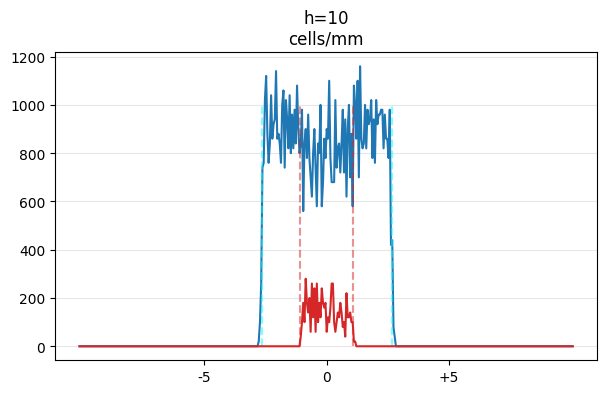

hour =   11 / 300
hour =   12 / 300
hour =   13 / 300
hour =   14 / 300
hour =   15 / 300
hour =   16 / 300
hour =   17 / 300
hour =   18 / 300
hour =   19 / 300
hour =   20 / 300


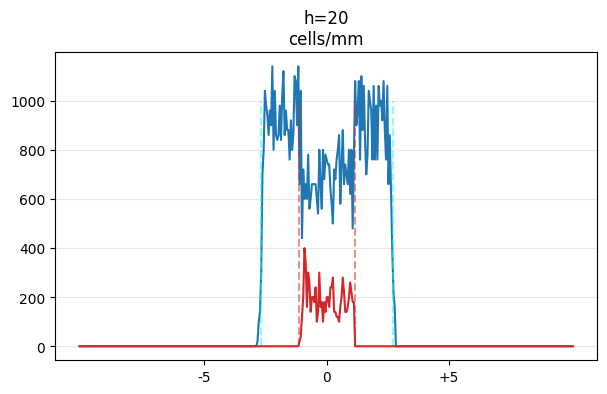

hour =   21 / 300
hour =   22 / 300
hour =   23 / 300
hour =   24 / 300
hour =   25 / 300
hour =   26 / 300
hour =   27 / 300
hour =   28 / 300
hour =   29 / 300
hour =   30 / 300


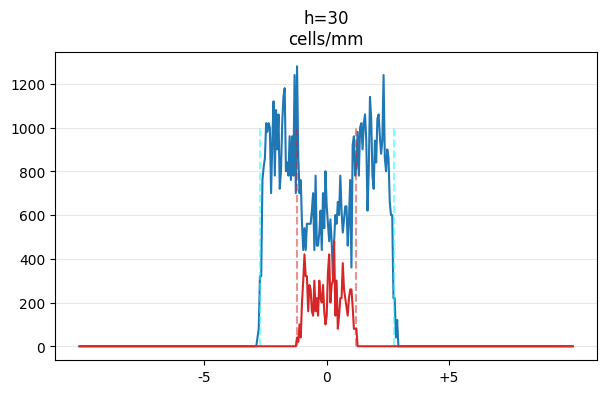

hour =   31 / 300
hour =   32 / 300
hour =   33 / 300
hour =   34 / 300
hour =   35 / 300
hour =   36 / 300
hour =   37 / 300
hour =   38 / 300
hour =   39 / 300
hour =   40 / 300


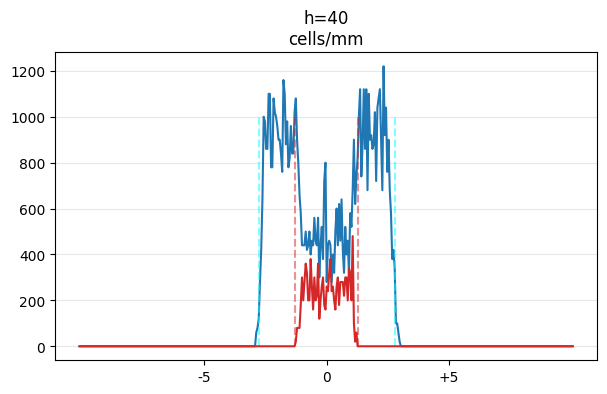

hour =   41 / 300
hour =   42 / 300
hour =   43 / 300
hour =   44 / 300
hour =   45 / 300
hour =   46 / 300
hour =   47 / 300
hour =   48 / 300
hour =   49 / 300
hour =   50 / 300


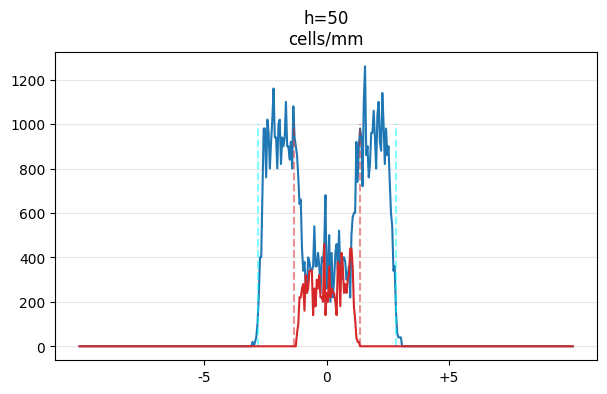

hour =   51 / 300
hour =   52 / 300
hour =   53 / 300
hour =   54 / 300
hour =   55 / 300
hour =   56 / 300
hour =   57 / 300
hour =   58 / 300
hour =   59 / 300
hour =   60 / 300


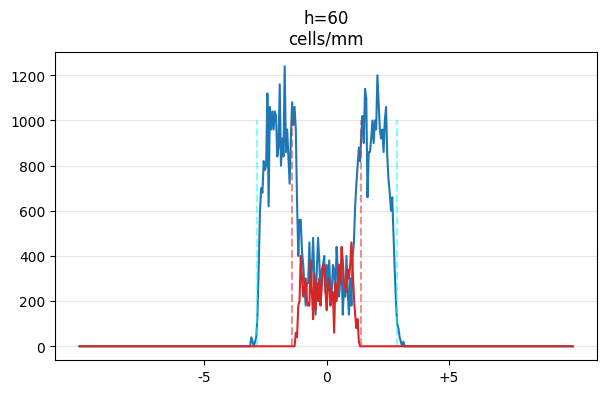

hour =   61 / 300
hour =   62 / 300
hour =   63 / 300
hour =   64 / 300
hour =   65 / 300
hour =   66 / 300
hour =   67 / 300
hour =   68 / 300
hour =   69 / 300
hour =   70 / 300


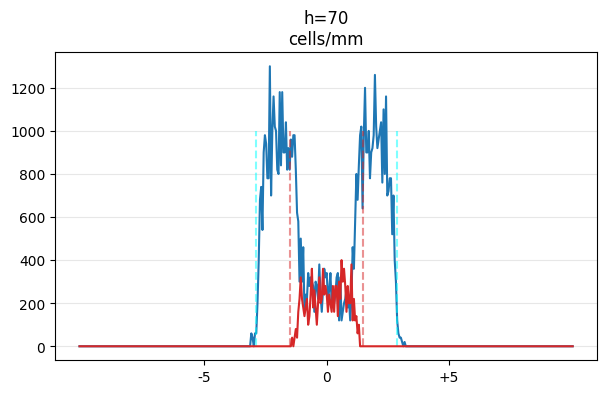

hour =   71 / 300
hour =   72 / 300
hour =   73 / 300
hour =   74 / 300
hour =   75 / 300
hour =   76 / 300
hour =   77 / 300
hour =   78 / 300
hour =   79 / 300
hour =   80 / 300


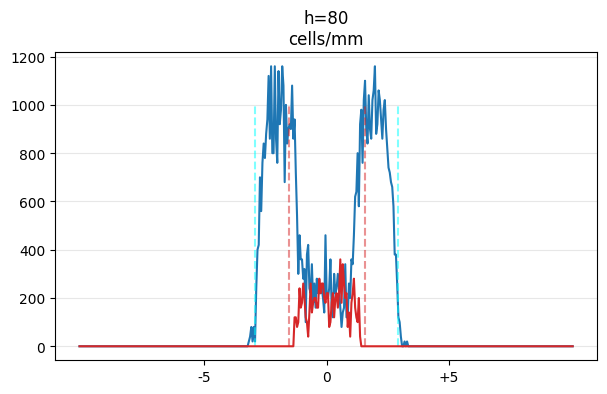

hour =   81 / 300
hour =   82 / 300
hour =   83 / 300
hour =   84 / 300
hour =   85 / 300
hour =   86 / 300
hour =   87 / 300
hour =   88 / 300
hour =   89 / 300
hour =   90 / 300


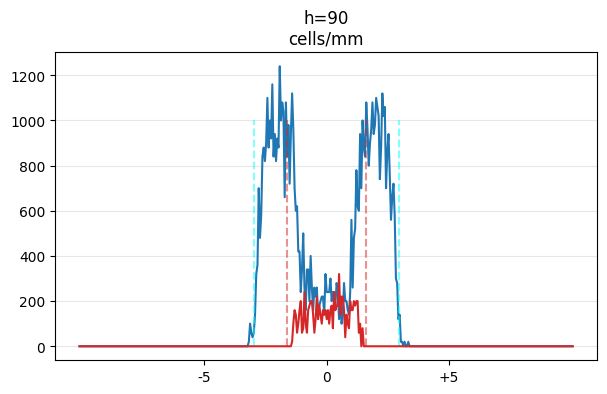

hour =   91 / 300
hour =   92 / 300
hour =   93 / 300
hour =   94 / 300
hour =   95 / 300
hour =   96 / 300
hour =   97 / 300
hour =   98 / 300
hour =   99 / 300
hour =  100 / 300


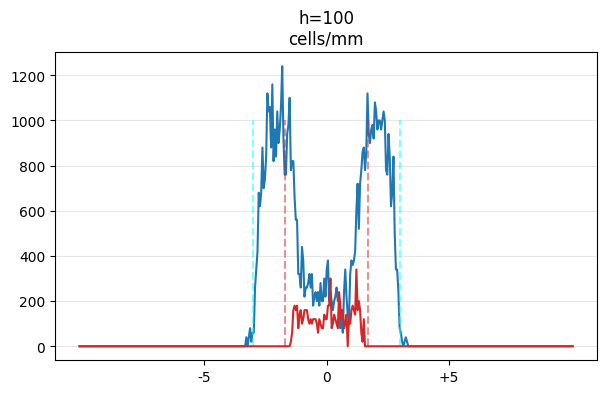

hour =  101 / 300
hour =  102 / 300
hour =  103 / 300
hour =  104 / 300
hour =  105 / 300
hour =  106 / 300
hour =  107 / 300
hour =  108 / 300
hour =  109 / 300
hour =  110 / 300


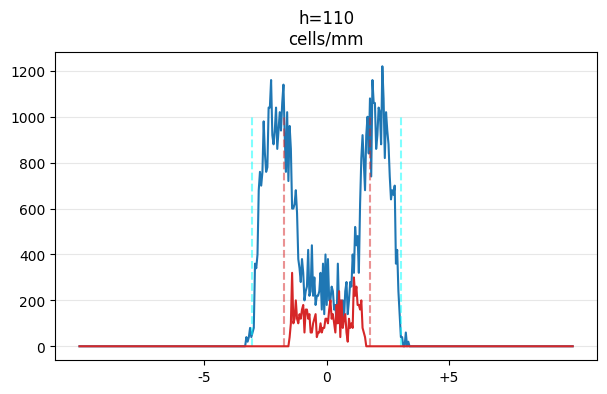

hour =  111 / 300
hour =  112 / 300
hour =  113 / 300
hour =  114 / 300
hour =  115 / 300
hour =  116 / 300
hour =  117 / 300
hour =  118 / 300
hour =  119 / 300
hour =  120 / 300


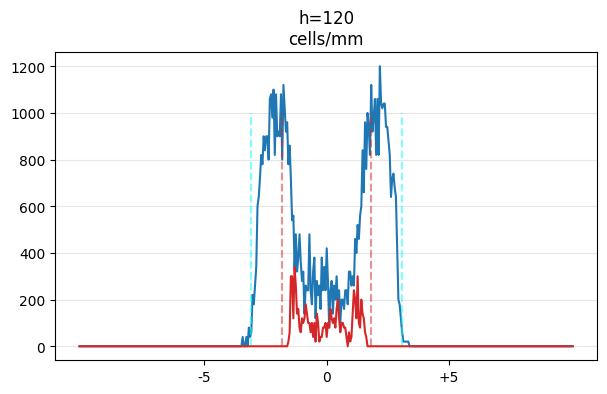

hour =  121 / 300
hour =  122 / 300
hour =  123 / 300
hour =  124 / 300
hour =  125 / 300
hour =  126 / 300
hour =  127 / 300
hour =  128 / 300
hour =  129 / 300
hour =  130 / 300


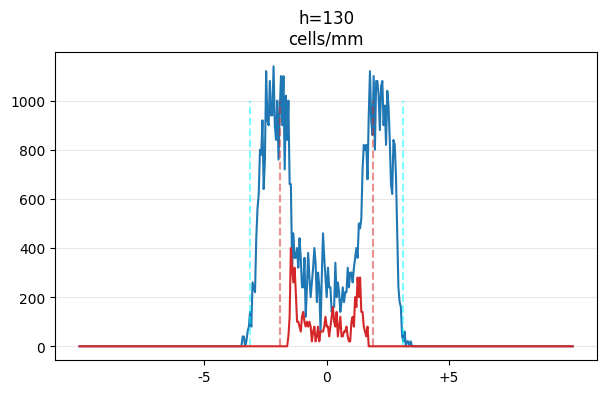

hour =  131 / 300
hour =  132 / 300
hour =  133 / 300
hour =  134 / 300
hour =  135 / 300
hour =  136 / 300
hour =  137 / 300
hour =  138 / 300
hour =  139 / 300
hour =  140 / 300


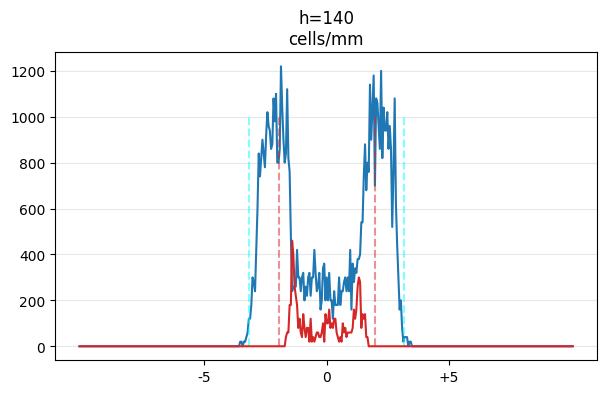

hour =  141 / 300
hour =  142 / 300
hour =  143 / 300
hour =  144 / 300
hour =  145 / 300
hour =  146 / 300
hour =  147 / 300
hour =  148 / 300
hour =  149 / 300
hour =  150 / 300


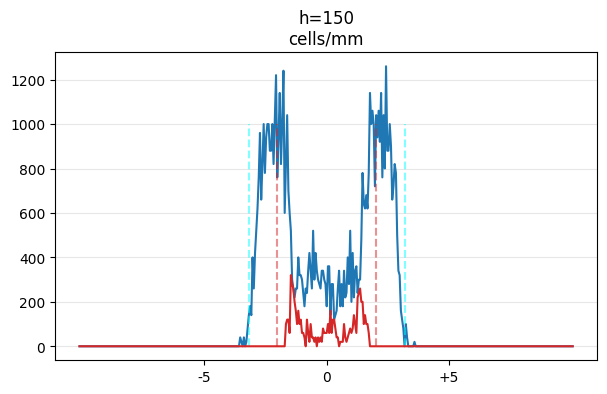

hour =  151 / 300
hour =  152 / 300
hour =  153 / 300
hour =  154 / 300
hour =  155 / 300
hour =  156 / 300
hour =  157 / 300
hour =  158 / 300
hour =  159 / 300
hour =  160 / 300


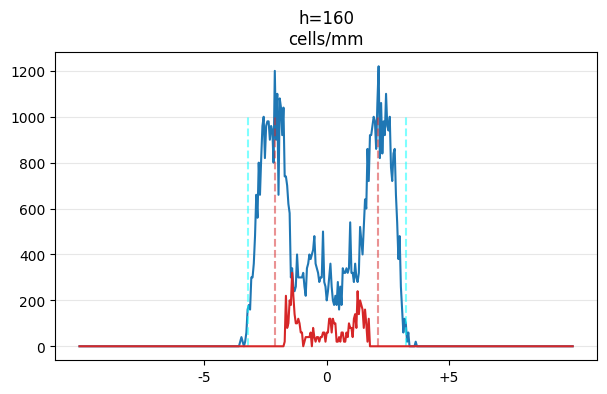

hour =  161 / 300
hour =  162 / 300
hour =  163 / 300
hour =  164 / 300
hour =  165 / 300
hour =  166 / 300
hour =  167 / 300
hour =  168 / 300
hour =  169 / 300
hour =  170 / 300


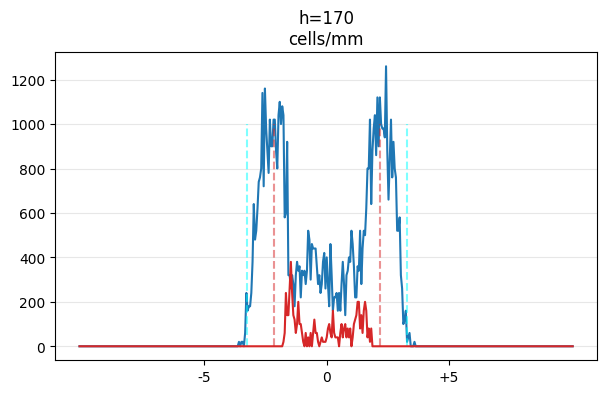

hour =  171 / 300
hour =  172 / 300
hour =  173 / 300
hour =  174 / 300
hour =  175 / 300
hour =  176 / 300
hour =  177 / 300
hour =  178 / 300
hour =  179 / 300
hour =  180 / 300


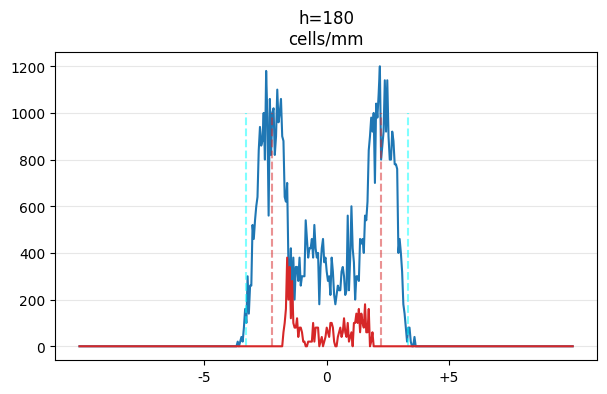

hour =  181 / 300
hour =  182 / 300
hour =  183 / 300
hour =  184 / 300
hour =  185 / 300
hour =  186 / 300
hour =  187 / 300
hour =  188 / 300
hour =  189 / 300
hour =  190 / 300


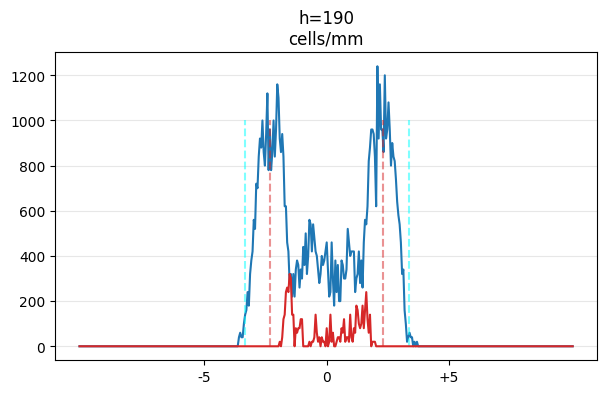

hour =  191 / 300
hour =  192 / 300
hour =  193 / 300
hour =  194 / 300
hour =  195 / 300
hour =  196 / 300
hour =  197 / 300
hour =  198 / 300
hour =  199 / 300
hour =  200 / 300


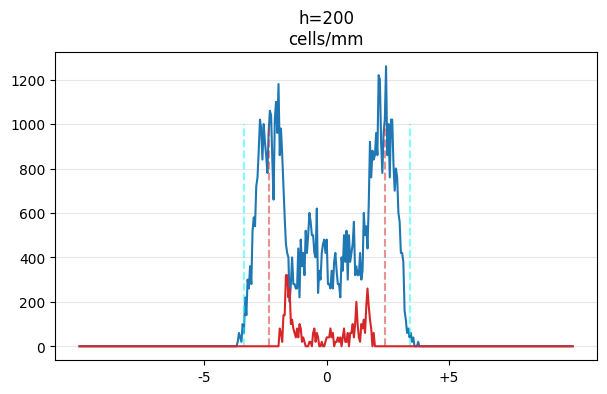

hour =  201 / 300
hour =  202 / 300
hour =  203 / 300
hour =  204 / 300
hour =  205 / 300
hour =  206 / 300
hour =  207 / 300
hour =  208 / 300
hour =  209 / 300
hour =  210 / 300


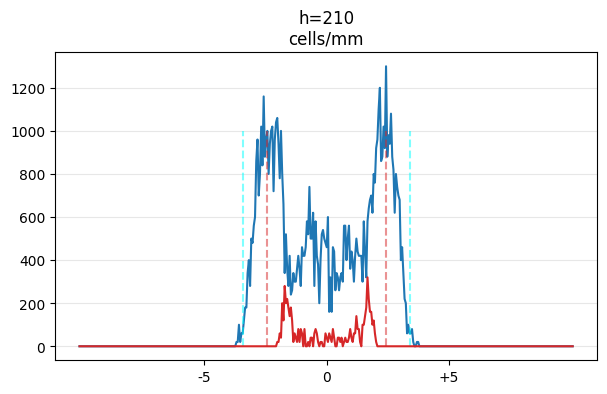

hour =  211 / 300
hour =  212 / 300
hour =  213 / 300
hour =  214 / 300
hour =  215 / 300
hour =  216 / 300
hour =  217 / 300
hour =  218 / 300
hour =  219 / 300
hour =  220 / 300


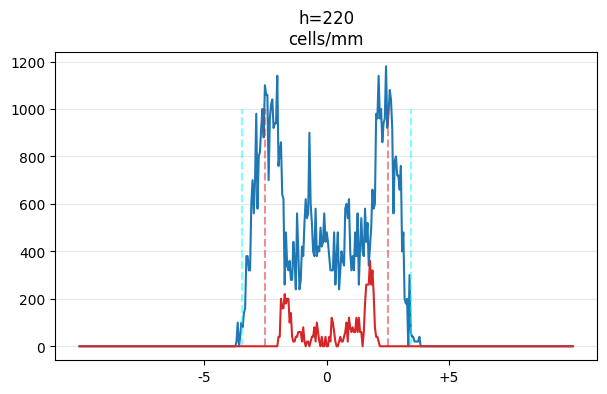

hour =  221 / 300
hour =  222 / 300
hour =  223 / 300
hour =  224 / 300
hour =  225 / 300
hour =  226 / 300
hour =  227 / 300
hour =  228 / 300
hour =  229 / 300
hour =  230 / 300


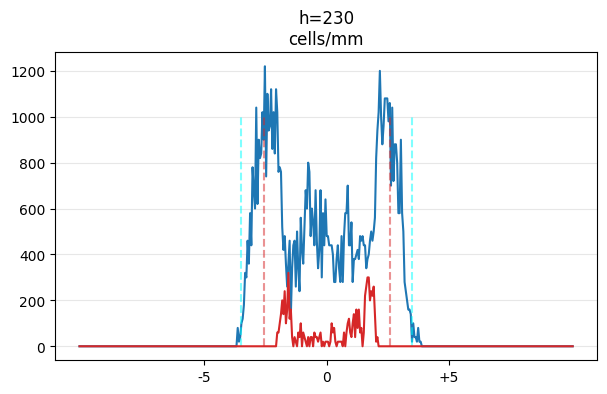

hour =  231 / 300
hour =  232 / 300
hour =  233 / 300
hour =  234 / 300
hour =  235 / 300
hour =  236 / 300
hour =  237 / 300
hour =  238 / 300
hour =  239 / 300
hour =  240 / 300


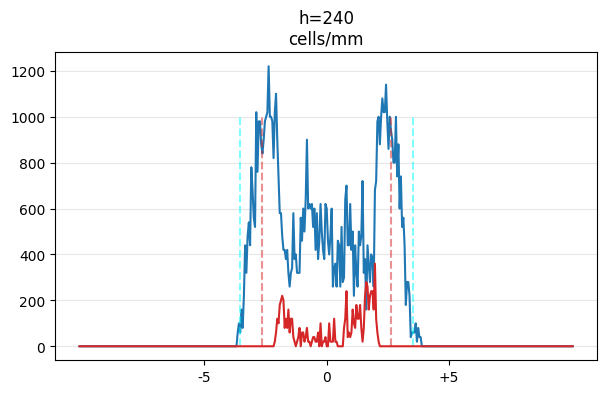

hour =  241 / 300
hour =  242 / 300
hour =  243 / 300
hour =  244 / 300
hour =  245 / 300
hour =  246 / 300
hour =  247 / 300
hour =  248 / 300
hour =  249 / 300
hour =  250 / 300


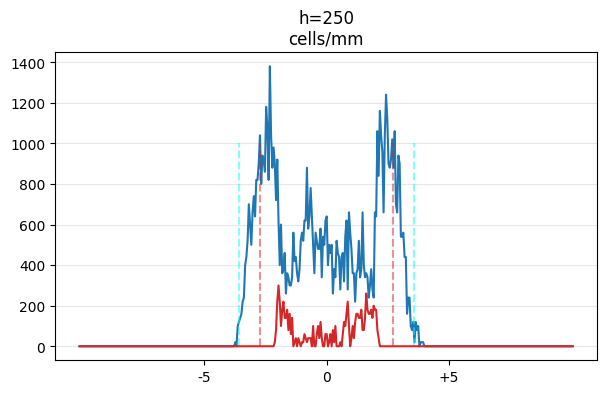

hour =  251 / 300
hour =  252 / 300
hour =  253 / 300
hour =  254 / 300
hour =  255 / 300
hour =  256 / 300
hour =  257 / 300
hour =  258 / 300
hour =  259 / 300
hour =  260 / 300


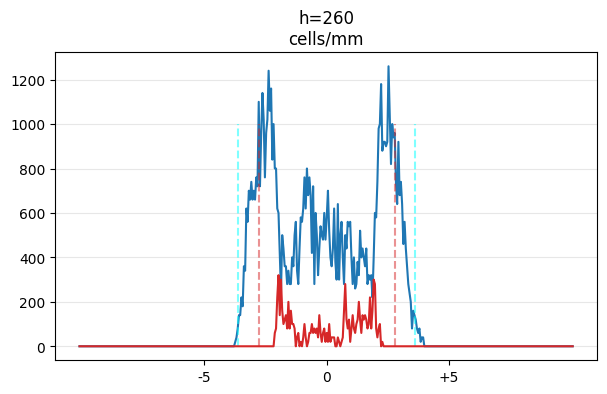

hour =  261 / 300
hour =  262 / 300
hour =  263 / 300
hour =  264 / 300
hour =  265 / 300
hour =  266 / 300
hour =  267 / 300
hour =  268 / 300
hour =  269 / 300
hour =  270 / 300


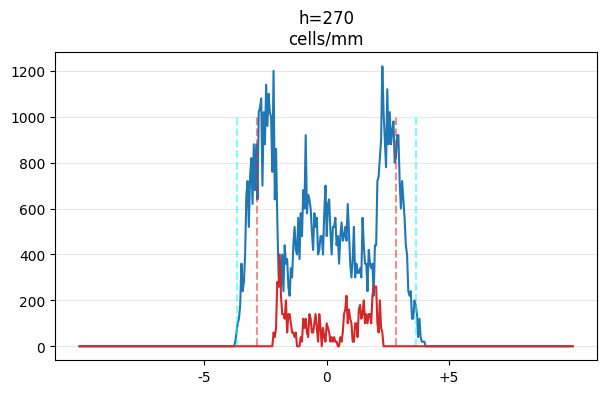

hour =  271 / 300
hour =  272 / 300
hour =  273 / 300
hour =  274 / 300
hour =  275 / 300
hour =  276 / 300
hour =  277 / 300
hour =  278 / 300
hour =  279 / 300
hour =  280 / 300


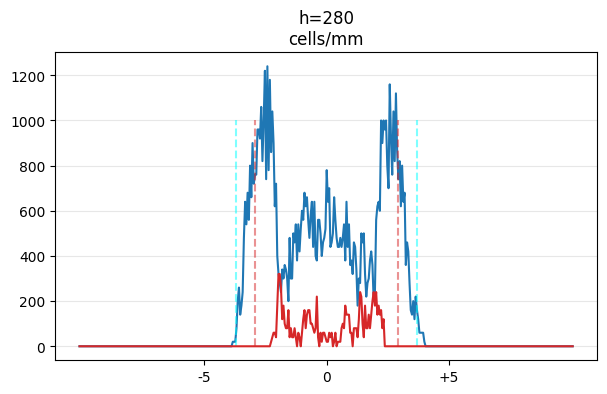

hour =  281 / 300
hour =  282 / 300
hour =  283 / 300
hour =  284 / 300
hour =  285 / 300
hour =  286 / 300
hour =  287 / 300
hour =  288 / 300
hour =  289 / 300
hour =  290 / 300


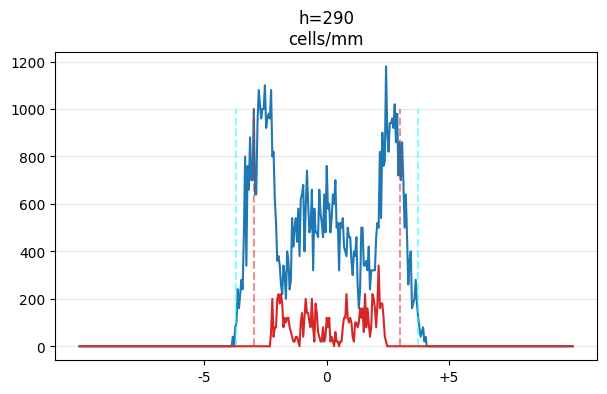

hour =  291 / 300
hour =  292 / 300
hour =  293 / 300
hour =  294 / 300
hour =  295 / 300
hour =  296 / 300
hour =  297 / 300
hour =  298 / 300
hour =  299 / 300
hour =  300 / 300


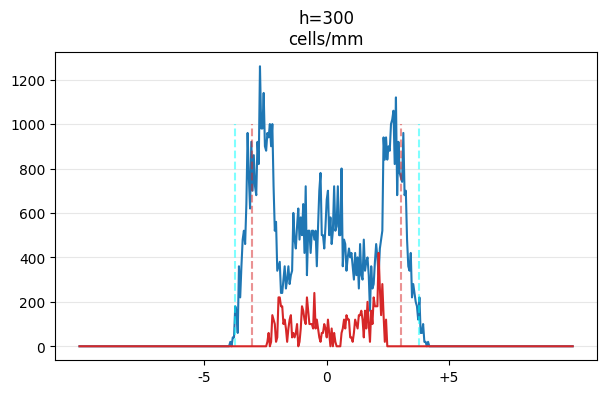

In [7]:
# simulate

# code to use in case of recovered simulation:
# rec_h = 630
# domain = np.load(f"{SIM_FOLDER}/sim{SIM}_h{rec_h}.npy")

domain = random_walk_1D(domain, domain.copy(), tot_hours=300) # h=rec_h